# Predicting Flight Disruptions in the Post COVID-19 Era 
##### Technical Notes by 220029955 for ID5059 2022-23: Coursework Assignment 1

### Introduction
This python notebook will explore a very large dataset on flights in North America from 2018 to 2022. This dataset contains millions of commercial flight information, including flights with disruption (i.e. flights that were delayed, diverted or cancelled). In addition, the dataset also contains flights in 2020 and 2021 during the peak of the COVID-19 pandemic.

Forecasting flight disruptions would be useful for airline companies in planning weekly and daily flight and flight replacements, as well as commercial passengers who may want to rebook if they know there's a high chance of disruptions. In addition, determining if COVID-19 had an effect on flight disruptions will also help airline companies and governments in planning alternative means of transportation in future cases of pandemics.

The analysis here will attempt to determine whether COVID-19 had any effect on flight disruptions, as well as predict disruptions for future flights. 

### Loading the Data

The entire dataset is 7.60GB and has already been split into training and test sets. With the training data is loaded, we can see that it is 23 million rows long and 64 columns wide. This will need to be cleaned for this analysis.

The exploratory analysis will be conducted using the training set, while both training and testing sets will be used for model building and testing.

In [1]:
# We first load the necessary python libraries

# Data Wrangling
import glob
import pandas as pd
import numpy as np

# Visualisation
import seaborn.objects as so

# COVID Impact Assessment
from scipy.stats import chisquare

# Data Prep Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Model building and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Cross Validation
from sklearn.model_selection import cross_val_score

# Testing Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

C:\Users\Josh\AppData\Local\Temp\ipykernel_10824\368372403.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


The data is contained in separate csv files (one for each year). We load each one then concatenate them into a single dataset.

In [2]:
# Create a list of files in the data directoy
csvs = glob.glob("4_huge/Combined_Flights_train_*")

# If performance suffers, try the medium set here
# csvs = glob.glob("2_medium/*")

# Create an empty dataframe
flights = pd.DataFrame()

# Append each csv into the dataframe
flights = pd.concat((pd.read_csv(csv) for csv in csvs))


# Clear the maximum number of columns to be displayed, so that all will be visible.
pd.set_option('display.max_columns', None)

display(flights)

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,CRSElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,DestCityName,DestState,DestStateFips,DestStateName,DestWac,DepTimeBlk,CRSArrTime,ArrDel15,ArrTimeBlk,DistanceGroup,Disruption,Unnamed: 0,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,ActualElapsedTime,DepDel15,DepartureDelayGroups,TaxiOut,WheelsOff,WheelsOn,TaxiIn,ArrDelay,ArrivalDelayGroups,DivAirportLandings
0,2018-01-23,Endeavor Air Inc.,ABY,ATL,0,0,1202,62.0,145,2018,1,1,23,2,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N8928A,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,1200-1259,1304,0.0,1300-1359,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-25,Endeavor Air Inc.,ABY,ATL,0,0,1202,62.0,145,2018,1,1,25,4,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N8836A,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,1200-1259,1304,0.0,1300-1359,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-27,Endeavor Air Inc.,ABY,ATL,0,0,1400,60.0,145,2018,1,1,27,6,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N8839E,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,1400-1459,1500,0.0,1500-1559,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-28,Endeavor Air Inc.,ABY,ATL,0,0,1202,62.0,145,2018,1,1,28,7,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N8918B,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,1200-1259,1304,1.0,1300-1359,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-29,Endeavor Air Inc.,ABY,ATL,0,0,1202,62.0,145,2018,1,1,29,1,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N8783E,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,1200-1259,1304,0.0,1300-1359,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3262650,2022-03-31,Republic Airlines,MSY,EWR,0,1,1949,185.0,1167,2022,1,3,31,4,UA,UA_CODESHARE,19977,UA,3621,YX,20452,YX,N745YX,3621,13495,1349505,33495,"New Orleans, LA",LA,22,Louisiana,72,11618,1161802,31703,"Newark, NJ",NJ,34,New Jersey,21,1900-1959,2354,NaN,2300-2359,5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3262651,2022-03-17,Republic Airlines,CLT,EWR,1,0,1733,129.0,529,2022,1,3,17,4,UA,UA_CODESHARE,19977,UA,3437,YX,20452,YX,N654RW,3437,11057,1105703,31057,"Charlotte, NC",NC,37,North Carolina,36,11618,1161802,31703,"Newark, NJ",NJ,34,New Jersey,21,1700-1759,1942,NaN,1900-1959,3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3262652,2022-03-08,Republic Airlines,ALB,ORD,0,0,1700,158.0,723,2022,1,3,8,2,UA,UA_CODESHARE,19977,UA,3413,YX,20452,YX,N733YX,3413,10257,1025702,30257,"Albany, NY",NY,36,New York,22,13930,1393007,30977,"Chicago, IL",IL,17,Illinois,41,1700-1759,1838,1.0,1800-1859,3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3262653,2022-03-25,Republic Airlines,EWR,PIT,0,1,2129,86.0,319,2022,1,3,25,5,UA,UA_CODESHARE,19977,UA,3450,YX,20452,YX,N647RW,3450,11618,1161802,31703,"Newark, NJ",NJ,34,New 

We check the dataframe's dimensions, and do a quick check on some columns to see if the values make sense.

In [3]:
# We check the shape of the dataset and see that it has over 23 million rows and 64 columns!
flights.shape

(23355028, 63)

In [4]:
# We also check some columns to see if python read in the data correctly and none of the value shifted to the other columns.
# Here we can see that they have been successfully loaded in, and the values make sense relative to their colummn headers.
# We do notice that 'Disruption' column has some 'nan' values. We will deal with this later.

print( "Unique values in 'Quarter' :", flights['Quarter'].unique())
print( "\nUnique values in 'Year' :", flights['Year'].unique())
print( "\nUnique values in 'OriginState' :", flights['OriginState'].unique())
print( "\nUnique values in 'Disruption' :", flights['Disruption'].unique())

Unique values in 'Quarter' : [1 4 2 3]

Unique values in 'Year' : [2018 2019 2020 2021 2022]

Unique values in 'OriginState' : ['GA' 'AL' 'NY' 'TX' 'VT' 'VA' 'NC' 'MO' 'MN' 'WI' 'MI' 'FL' 'LA' 'IN'
 'OH' 'IL' 'ME' 'TN' 'KY' 'SC' 'ND' 'AR' 'MA' 'OK' 'WV' 'MS' 'PA' 'NE'
 'MD' 'IA' 'NH' 'CT' 'NJ' 'PR' 'UT' 'CA' 'NV' 'CO' 'WA' 'VI' 'RI' 'OR'
 'AZ' 'NM' 'MT' 'ID' 'SD' 'KS' 'HI' 'WY' 'TT' 'AK' 'DE']

Unique values in 'Disruption' : [ 0.  1. nan]


### Exploratory Analysis
Here we explore possible relationships and trends, which will help determine how to transform our data and decide which columns to use for our COVID analysis and machine learning models.

First, we deal with 'nan' values in our target column 'Disruption'. Since we will be visualising the proportions of disruptions relative to other columns, we want to make sure this column is clean. 

We can see that there are several rows affected (over 6 million!), so we will replace these by 'rebuilding' the entire column. We will assign '1' if the flight has been cancelled, diverted, or delayed at least 15 minutes (i.e. if column'Cancelled' or 'Diverted' or 'ArrDel15' has a value of 1).

In [5]:
# Checking if there are any null values in the dataset's response variable ('Disruption').
# Looks like there are several!
print ("Number of rows with 'nan' in 'Disruption' column: ", flights['Disruption'].isna().sum())

Number of rows with 'nan' in 'Disruption' column:  6473797


In [6]:
# We don't want any rows with 'nan', especially for 'Disruption', so we rebuild this column by assigning '1' if 'Cancelled', 'Diverted', or 'ArrDel15'. 
# Other variables with 'nan' will only be addressed later if we decide to keep them.
flights.reset_index(inplace=True)
flights['Disruption'] = np.where(((flights['Cancelled']==1) | (flights['Diverted']==1) | (flights['ArrDel15']==1)) , 1, 0)
print ("Number of rows with 'nan' in 'Disruption' column after rebuilding: ", flights['Disruption'].isna().sum())

Number of rows with 'nan' in 'Disruption' column after rebuilding:  0


#### Checking Correlations
Since we have several columns, we check to see if some are correlated to determine if they provide the same information (i.e. some columns might provide redundant data). Since there are 64 columns, this is an important step in paring down our data.

We'll also check how many unique values there are for some columns. We can see that some of these columns have hundreds or thousands of categorical values. We determine to drop these later on. 

In [7]:
# We check some variables to see how many unique values there are. 
# We can see that most of them are in the hundreds, and some are in the thousands!
# These will guide us on which variables to keep or drop.
print('Some colummns and the number of their unique values:\n')
print(flights[['Flight_Number_Operating_Airline',
                'Flight_Number_Marketing_Airline',
                'OriginAirportID','DestAirportID',
                'Tail_Number' ]].nunique())


Some colummns and the number of their unique values:

Flight_Number_Operating_Airline    7380
Flight_Number_Marketing_Airline    7356
OriginAirportID                     388
DestAirportID                       388
Tail_Number                        7088
dtype: int64


In [8]:
# # Let's check other columns to see their values. 
# # Here we can see that the 'Airline' columns have about the same number of unique values.
# # These might be correlated.

# print("Marketing Airline: ", flights['IATA_Code_Marketing_Airline'].unique(),
#       "\nDOT Airline: ", flights['DOT_ID_Marketing_Airline'].unique())

Now we check columns for correlations. We will go through these using the Kaggle data dictionary as our guide. First we compare 'Airline' related columns, then 'Airport' columns, 'State' columns, then 'Distance'.

From these comparisons, we determine to use only one column from each category.

In [9]:
# Let's check their correlations. Running this, we can see that the following are perfectly correlated (value of 1.0):
# 'Airline, 'Operating_Airline', 'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline', 'Operated_or_Branded_Code_Share_Partners'

# The following are also perfectly correlated with each other (value of 1.0): 
# 'Marketing_Airline_Network', 'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline'

# From this, we can decide to drop the following 'Airline', 'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline', 'Marketing_Airline_Network', 'DOT_ID_Marketing_Airline'

airline_columns = ["Airline", 
                    "Marketing_Airline_Network", 
                    "Operated_or_Branded_Code_Share_Partners",
                    "DOT_ID_Marketing_Airline",
                    "IATA_Code_Marketing_Airline",
                    "Flight_Number_Marketing_Airline",
                    "Operating_Airline",
                    "DOT_ID_Operating_Airline",
                    "IATA_Code_Operating_Airline",
                    "Flight_Number_Operating_Airline"]

flights[airline_columns].apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

,Airline,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Flight_Number_Operating_Airline
Airline,1.000000,0.536043,0.718764,0.536043,0.536043,0.105758,1.000000,1.000000,1.000000,0.105785
Marketing_Airline_Network,0.536043,1.000000,0.691925,1.000000,1.000000,0.041416,0.536043,0.536043,0.536043,0.041398
Operated_or_Branded_Code_Share_Partners,0.718764,0.691925,1.000000,0.691925,0.691925,0.044311,0.718764,0.718764,0.718764,0.044291
DOT_ID_Marketing_Airline,0.536043,1.000000,0.691925,1.000000,1.000000,0.041416,0.536043,0.536043,0.536043,0.041398
IATA_Code_Marketing_Airline,0.536043,1.000000,0.691925,1.000000,1.000000,0.041416,0.536043,0.536043,0.536043,0.041398
Flight_Number_Marketing_Airline,0.105758,0.041416,0.044311,0.041416,0.041416,1.000000,0.105758,0.105758,0.105758,0.999905
Operating_Airline,1.000000,0.536043,0.718764,0.536043,0.536043,0.105758,1.000000,1.000000,1.000000,0.105785
DOT_ID_Operating_Airline,1.000000,0.536043,0.718764,0.536043,0.536043,0.105758,1.000000,1.000000,1.000000,0.105785
IATA_Code_Operating_Airline,1.000000,0.536043,0.718764,0.536043,0.536043,0.105758,1.000000,1.000000,1.000000,0.105785
Flight_Number_Operating_Airline,0.105785,0.041398,0.044291,0.041398,0.041398,0.999905,0.105785,0.105785,0.105785,1.000000


In [10]:
# We do the same for Airport IDs.

# Based on the results below, the following are highly correlated:'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName'
# The following are also highly correlated: ''DestAirportID', 'DestAirportSeqID', 'DestCityMarketID','DestCityName'

# From this, the following should be dropped: 'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName'

airport_ids = ['Origin',
               'OriginAirportID',
               'OriginAirportSeqID',
               'OriginCityMarketID',
               'OriginCityName',
               'OriginWac',
               'Dest', 
               'DestAirportID', 
               'DestAirportSeqID', 
               'DestCityMarketID',
               'DestCityName',
               'DestWac']

flights[airport_ids].apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

,Origin,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,OriginCityName,OriginWac,Dest,DestAirportID,DestAirportSeqID,DestCityMarketID,DestCityName,DestWac
Origin,1.000000,1.000000,0.747590,0.790980,0.930356,0.505286,0.107738,0.107738,0.077189,0.137377,0.116431,0.230469
OriginAirportID,1.000000,1.000000,0.747590,0.790980,0.930356,0.505286,0.107738,0.107738,0.077189,0.137377,0.116431,0.230469
OriginAirportSeqID,0.747590,0.747590,1.000000,0.586832,0.701340,0.373753,0.078778,0.078778,0.056936,0.113477,0.089489,0.153888
OriginCityMarketID,0.790980,0.790980,0.586832,1.000000,0.851854,0.610903,0.134154,0.134154,0.110504,0.168052,0.147961,0.267082
OriginCityName,0.930356,0.930356,0.701340,0.851854,1.000000,0.555417,0.115674,0.115674,0.088893,0.147749,0.123777,0.239014
OriginWac,0.505286,0.505286,0.373753,0.610903,0.555417,1.000000,0.212961,0.212961,0.149025,0.261274,0.227676,0.378514
Dest,0.107738,0.107738,0.078778,0.134154,0.115674,0.212961,1.000000,1.000000,0.801739,0.829434,0.953457,0.606388
DestAirportID,0.107738,0.107738,0.078778,0.134154,0.115674,0.212961,1.000000,1.000000,0.801739,0.829434,0.953457,0.606388
DestAirportSeqID,0.077189,0.077189,0.056936,0.110504,0.088893,0.149025,0.801739,0.801739,1.000000,0.679347,0.772935,0.437433
DestCityMarketID,0.137377,0.137377,0.113477,0.168052,0.147749,0.261274,0.829434,0.829434,0.679347,1.000000,0.865568,0.667788


In [11]:
# We do the same with states as well.

# The origin columns are perfectly correlated, and the destination columns are correlated with each other as well.
# The following should be dropped 'OriginStateFips', 'OriginStateName', 'OriginWac', 'DestStateFips', 'DestStateName', 'DestWac'

states = ['OriginState',
          'OriginStateFips',
          'OriginStateName',
          'OriginWac',
          'DestState',
          'DestStateFips',
          'DestStateName',
          'DestWac']

flights[states].apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

,OriginState,OriginStateFips,OriginStateName,OriginWac,DestState,DestStateFips,DestStateName,DestWac
OriginState,1.000000,1.000000,1.000000,1.000000,0.378514,0.378514,0.378514,0.378514
OriginStateFips,1.000000,1.000000,1.000000,1.000000,0.378514,0.378514,0.378514,0.378514
OriginStateName,1.000000,1.000000,1.000000,1.000000,0.378514,0.378514,0.378514,0.378514
OriginWac,1.000000,1.000000,1.000000,1.000000,0.378514,0.378514,0.378514,0.378514
DestState,0.378514,0.378514,0.378514,0.378514,1.000000,1.000000,1.000000,1.000000
DestStateFips,0.378514,0.378514,0.378514,0.378514,1.000000,1.000000,1.000000,1.000000
DestStateName,0.378514,0.378514,0.378514,0.378514,1.000000,1.000000,1.000000,1.000000
DestWac,0.378514,0.378514,0.378514,0.378514,1.000000,1.000000,1.000000,1.000000


In [12]:
# Let's also check correlation of' Distance' and 'DistanceGroup'.

# Here we see they are almost perfectly correlated.

flights[['Distance','DistanceGroup']].corr()

,Distance,DistanceGroup
Distance,1.000000,0.986988
DistanceGroup,0.986988,1.000000


#### Checking Spread of Data
We also check distance and the time-related columns and how they affect disruptions.

Here we notice that distance is highly skewed, and that more flights are disrupted for shorter distances. We also notice that there are more flights scheduled at the top of the hour, and these have more disrupted flights. There also seems to be more flights in the first quarter of the year, although flights seem to be spread evenly across the days of the month and days of the week.

In [13]:
# First, we'll create a string version of our target variable 'Disruption' to aid in the visualisation
flights['Disruption?'] = flights['Disruption'].astype(str)

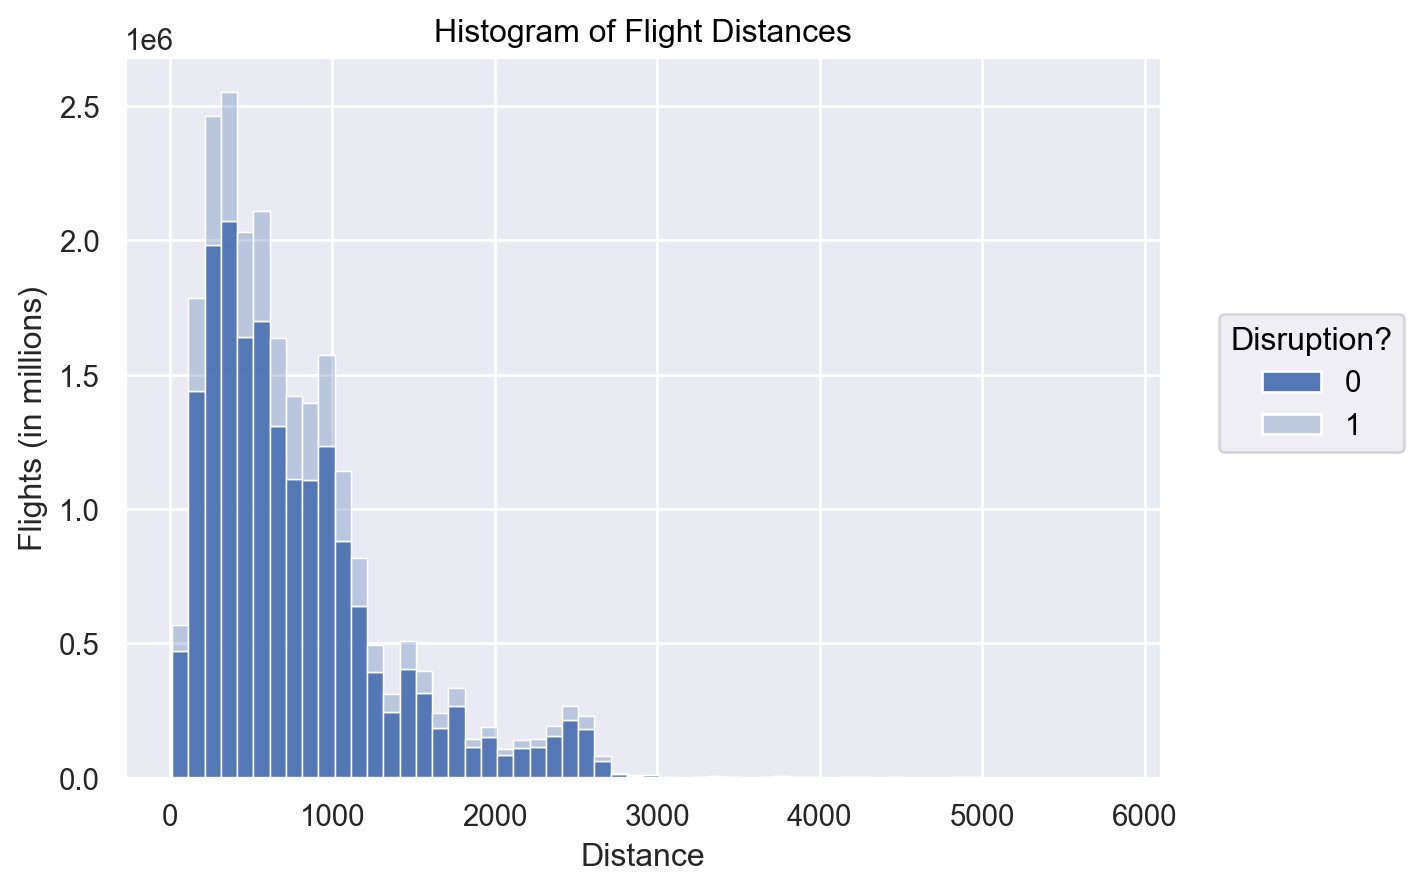

In [14]:
# We check the spread of 'Distance'
# We can see that it is skewed to the right, so we will apply scaling later on.

so.Plot(flights, x="Distance", alpha="Disruption?").add(so.Bars(),so.Hist(binwidth=100), so.Stack())\
    .label(title="Histogram of Flight Distances", x="Distance", y="Flights (in millions)")

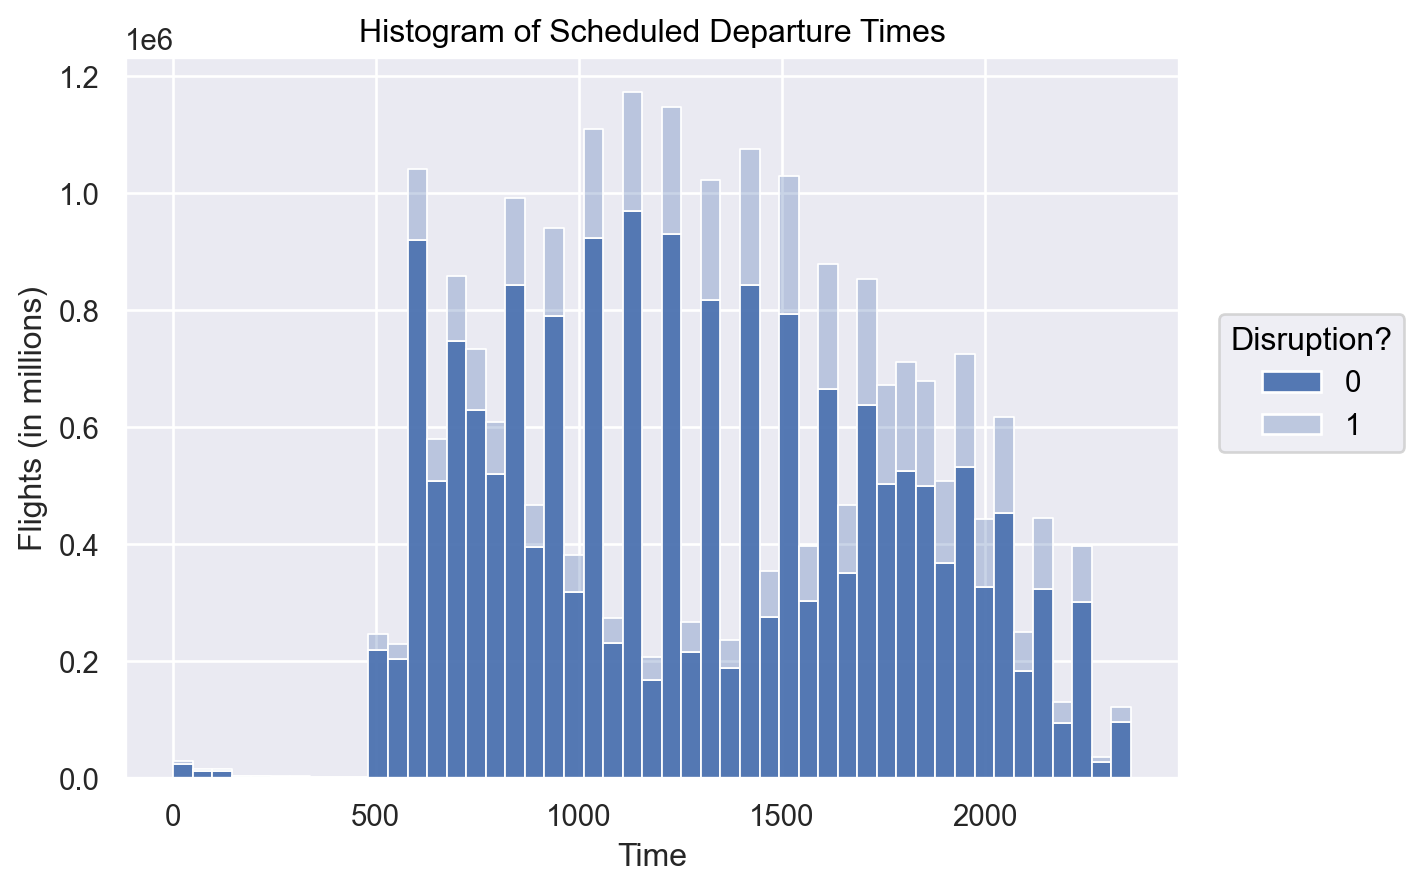

In [15]:
# We check 'CSRDepTime' and its effect on 'Disruption'.

# Here we can see that there are more flights at the top of the hour.
# These flights also have more disruptions.

so.Plot(flights, x="CRSDepTime", alpha="Disruption?").add(so.Bars(),so.Hist(binwidth=48), so.Stack())\
    .label(title="Histogram of Scheduled Departure Times", x="Time", y="Flights (in millions)")


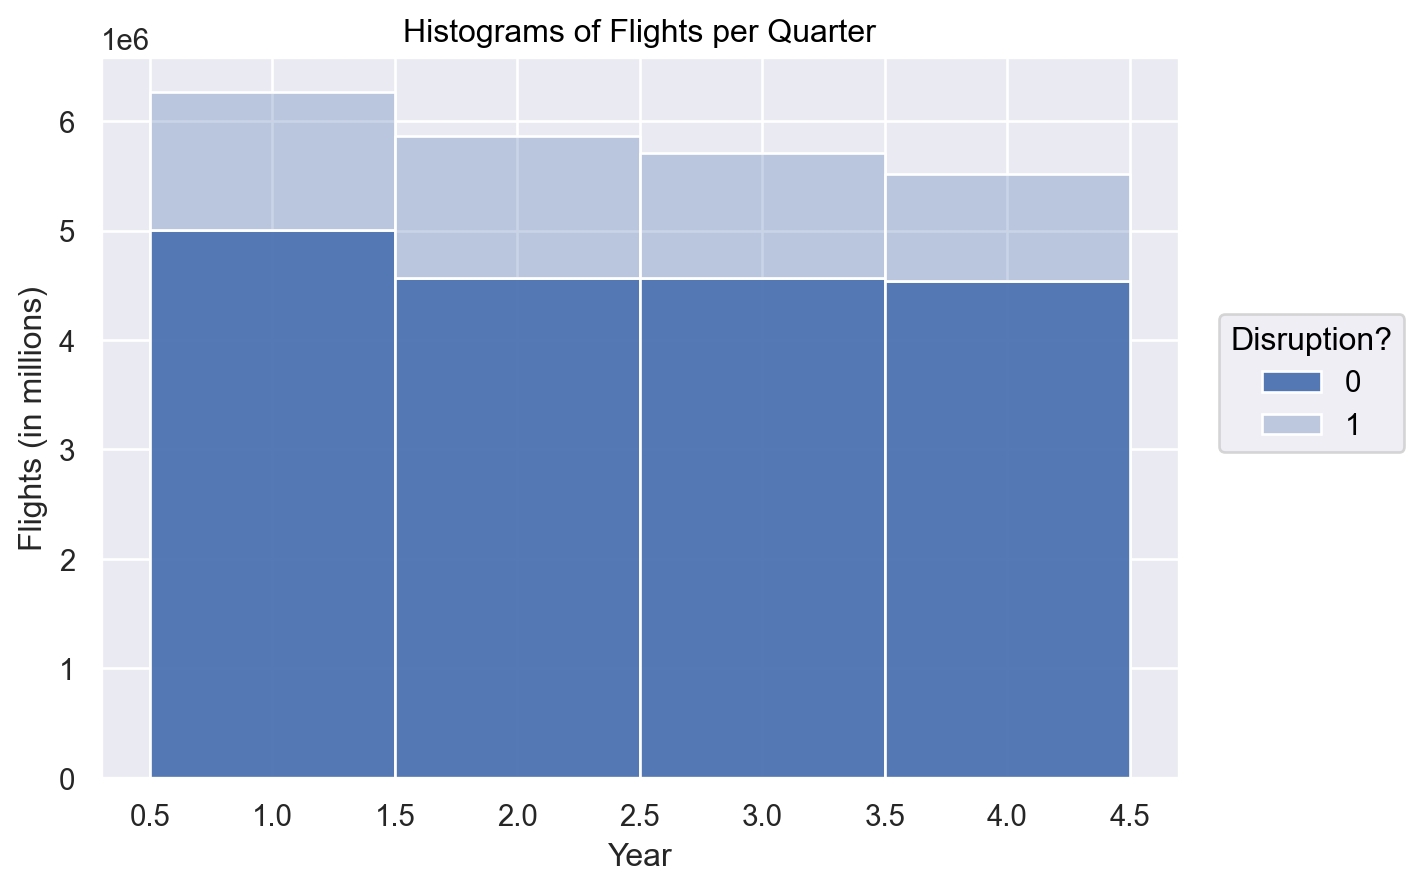

In [16]:
# Flights per Quarter
# There seem to be more flights in the earlier quarters

so.Plot(flights, x="Quarter", alpha="Disruption?").add(so.Bars(), so.Count(), so.Stack())\
    .label(title="Histograms of Flights per Quarter", x="Year", y="Flights (in millions)")

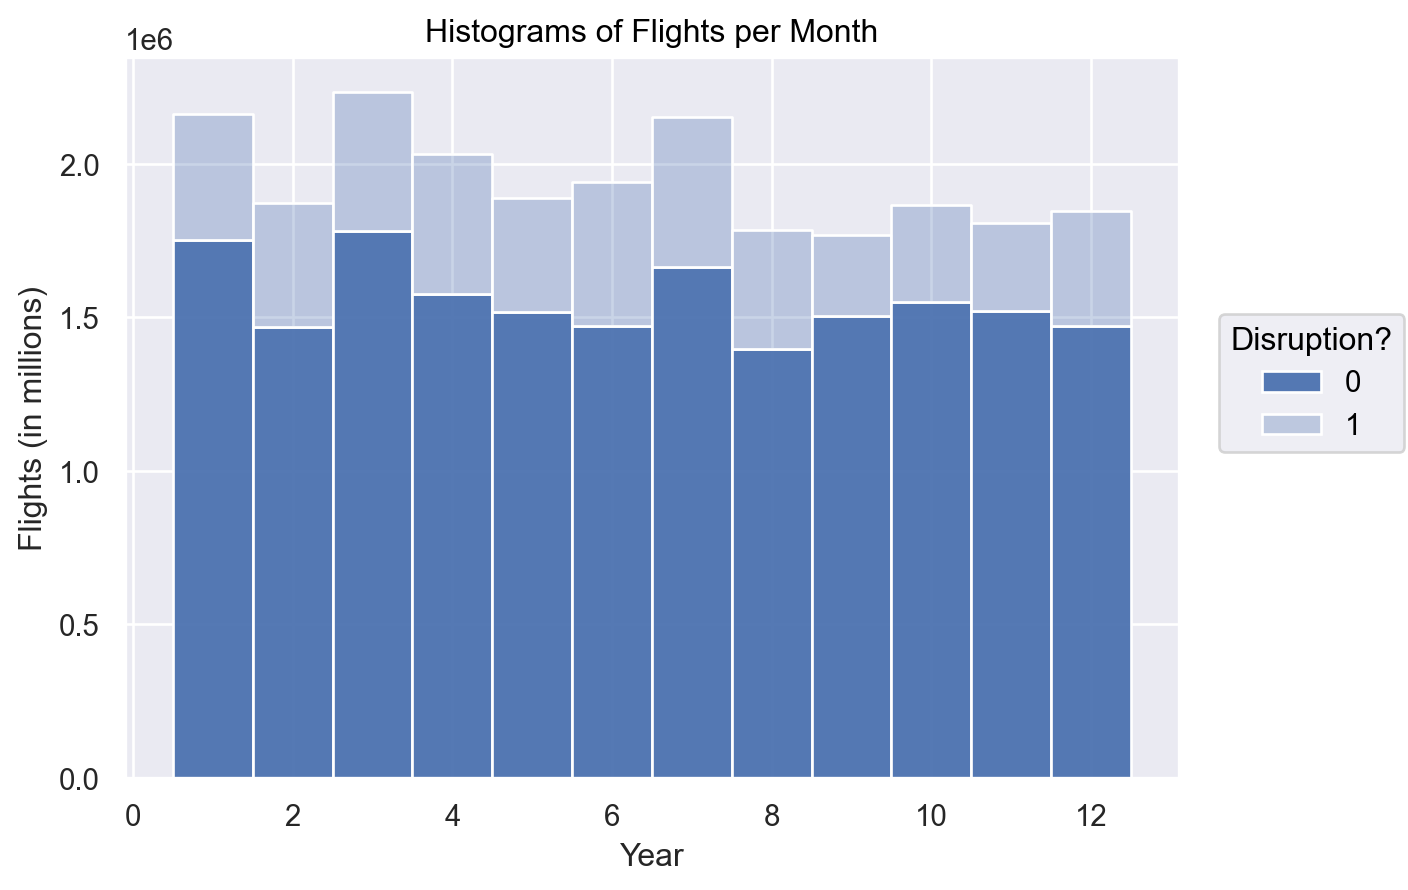

In [17]:
# Flights per Month
so.Plot(flights, x="Month", alpha="Disruption?").add(so.Bars(), so.Count(), so.Stack())\
    .label(title="Histograms of Flights per Month", x="Year", y="Flights (in millions)")


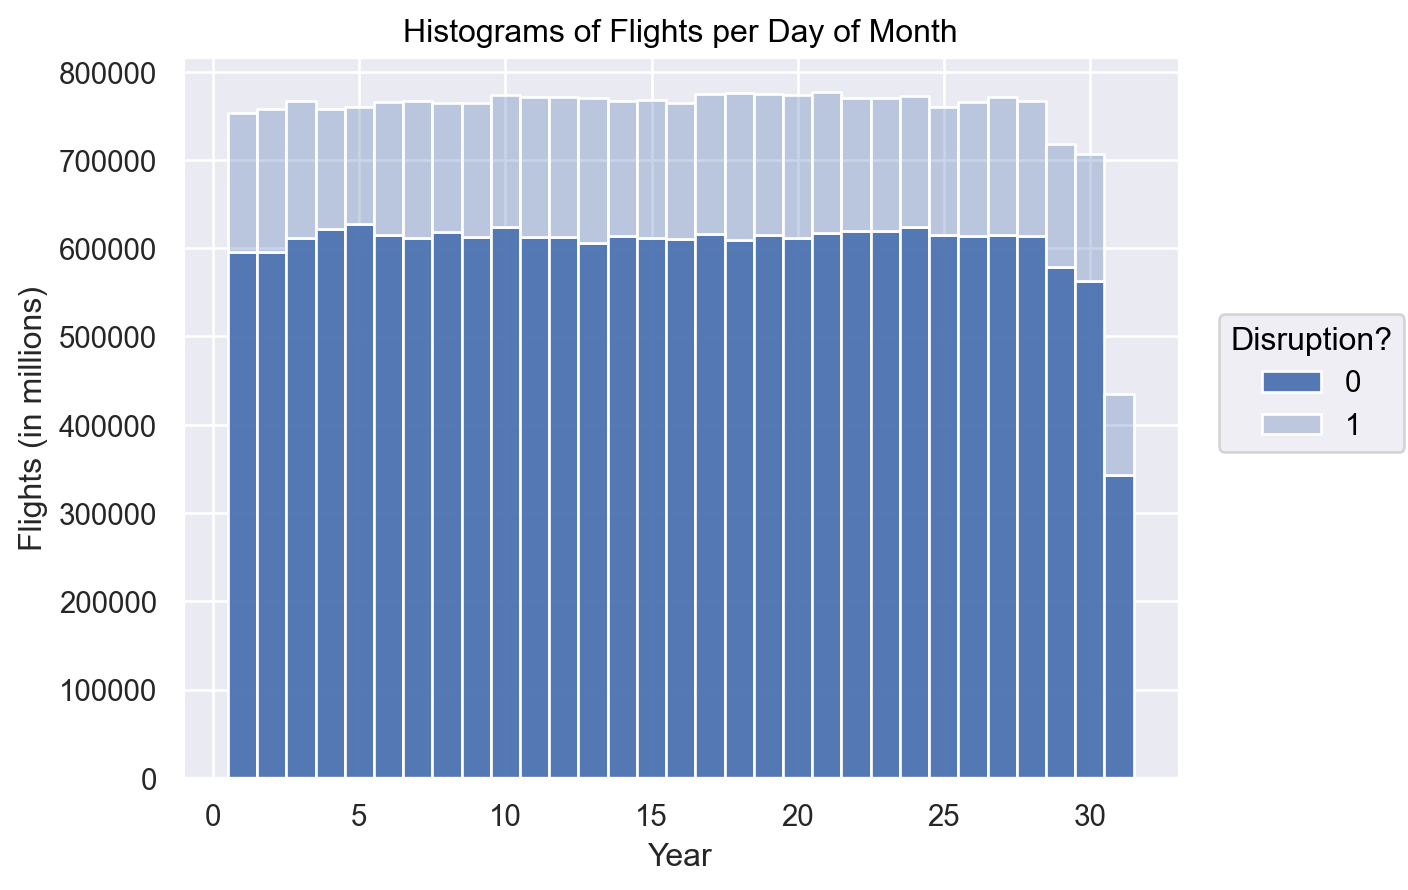

In [18]:
# Flights per Day of Month
so.Plot(flights, x="DayofMonth", alpha="Disruption?").add(so.Bars(), so.Count(), so.Stack())\
    .label(title="Histograms of Flights per Day of Month", x="Year", y="Flights (in millions)")

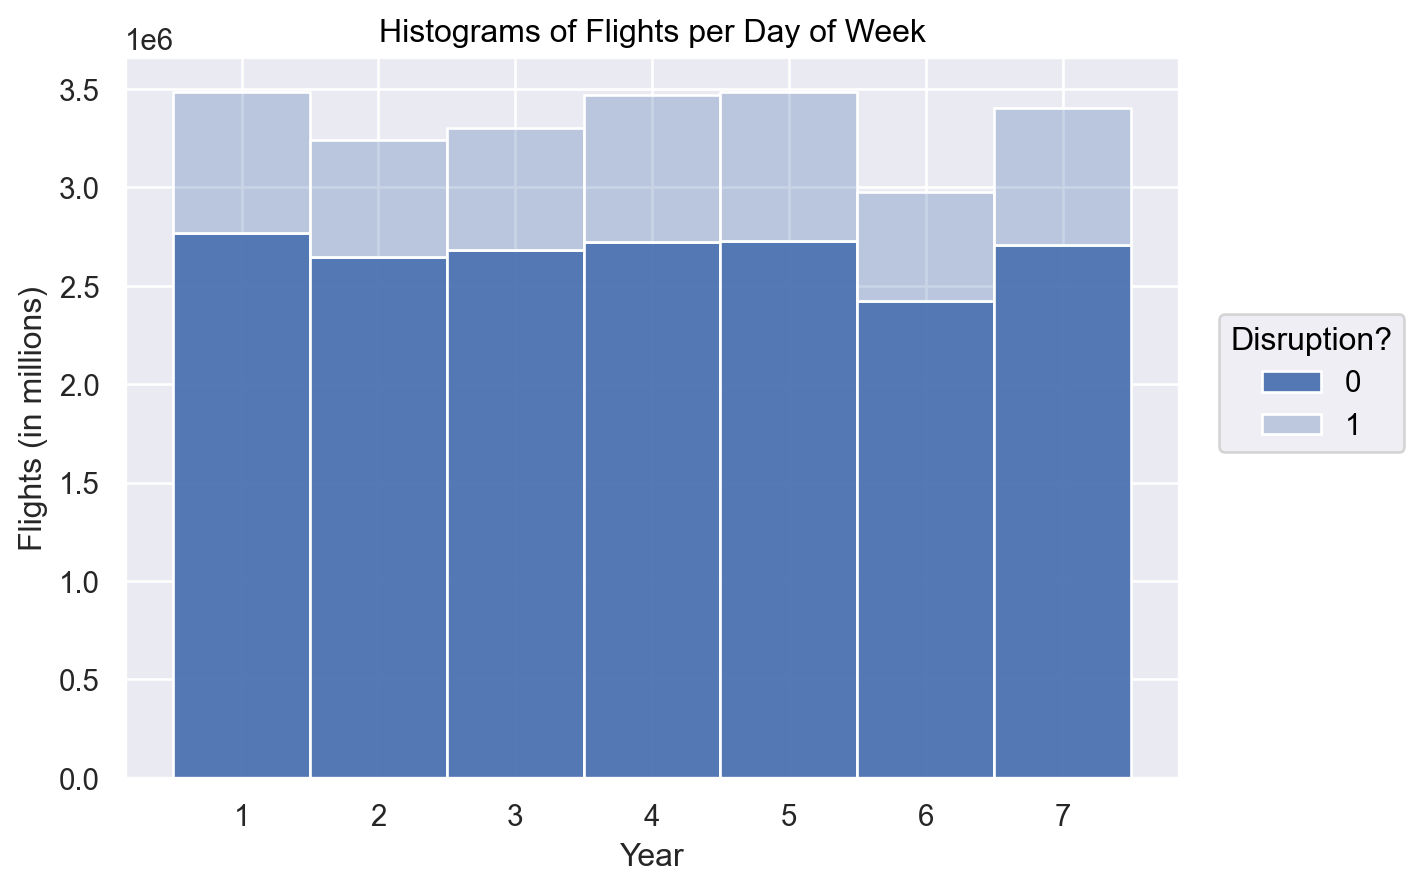

In [19]:
# Flights per Day of Week
so.Plot(flights, x="DayOfWeek", alpha="Disruption?").add(so.Bars(), so.Count(), so.Stack())\
    .label(title="Histograms of Flights per Day of Week", x="Year", y="Flights (in millions)")

### Assessing COVID-19 Impact on Flight Disruptions
Before building any machine learning models, lets assess the impact of COVID on the flights. This assessment shows that there seems to be fewer disruptions during the COVID years of 2020 and 2021 compared to 2019. However, this could be due to fewer flights overall for those 2 years.

The overall percentage of flights with non-disruption (for all years) is 0.79953 (or 79.95%), however when looking at non-disruptions for each year, we can see that they range from a low of 75.78% in non-COVID 2022 to a high of 84.51% in COVID 2020.

Running a Chi-square test, the p-value is 0.999..., which shows that there is no significant difference between the non-disruptions per year, so it can be stated that **COVID-19 did not have a significant impact on flight disruptions**.

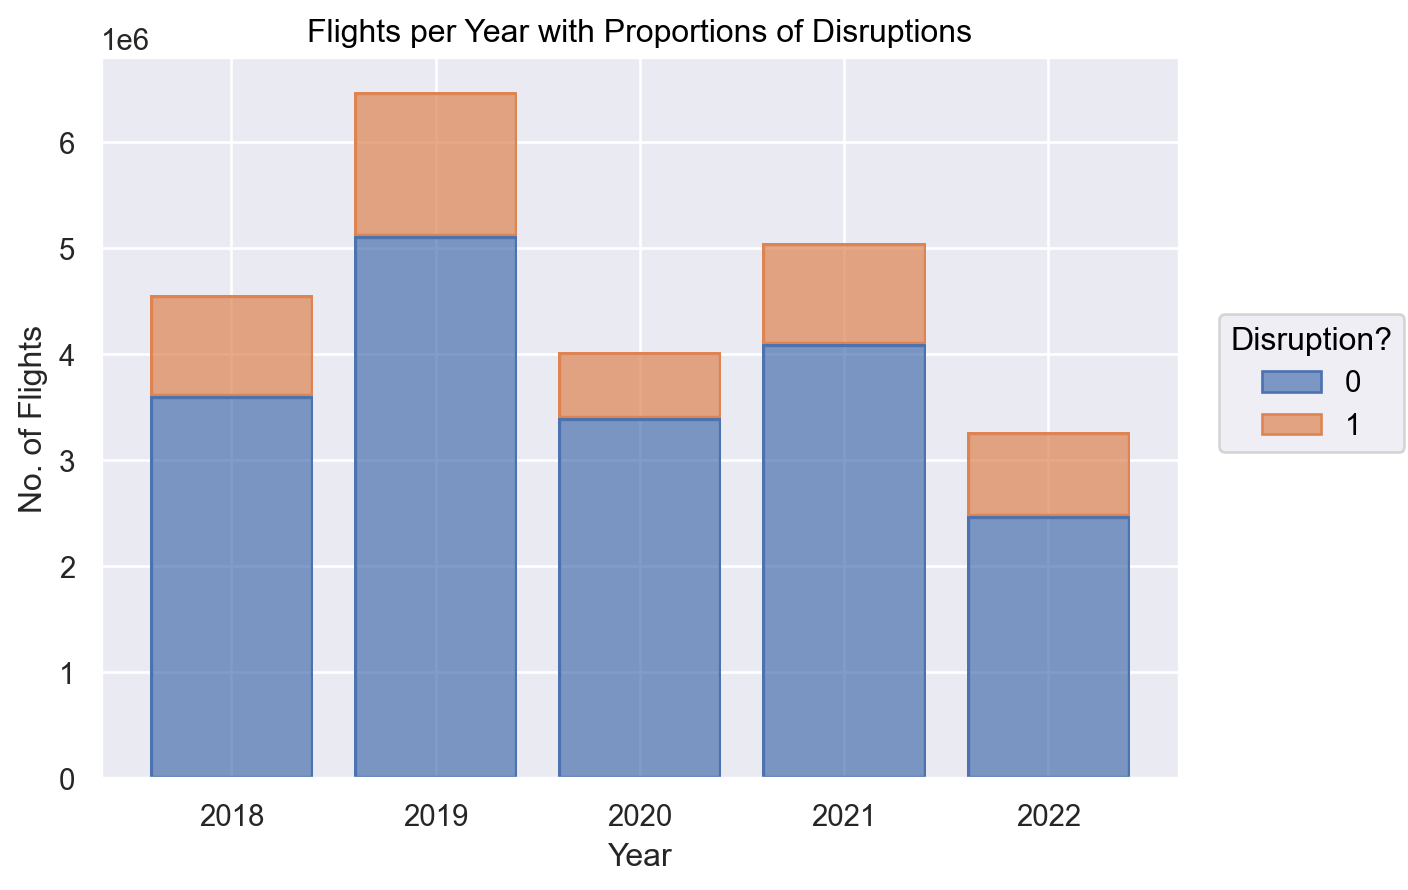

In [20]:
# Visualise the total flights per year, along with proportions of disruptions and non-disruptions.
# Here we see fewer flights overall for 2020 and 2021 (COVID years)compared to 2019.

so.Plot(flights, x="Year", color="Disruption?")\
    .add(so.Bar(), so.Count(),  so.Stack())\
    .label(title="Flights per Year with Proportions of Disruptions",x="Year", y="No. of Flights")


In [21]:
# Find the proportion of flights with non-disruptions for all years.

all_non_disrup = sum(flights['Disruption']==0.0)/len(flights['Disruption'])
print("The proportion of flights with non-disruptions is: ", round(all_non_disrup,5))

The proportion of flights with non-disruptions is:  0.79953


In [22]:
# Find the proportions of non-disruptions per year.

yearly_non_disrup = flights[flights['Disruption']==0.0].groupby('Year')['Disruption'].count() / flights.groupby('Year')['Disruption'].count()
print("Table 1: Proportion of non-disruptions per year: \n")
pd.DataFrame(yearly_non_disrup.round(5))

Table 1: Proportion of non-disruptions per year: 



,Disruption
Year,
2018,0.79072
2019,0.78967
2020,0.84510
2021,0.81083
2022,0.75780


In [23]:
# Run a chi-square test on the proportions per year. 
# The results show a non-significant p-value of 0.999...
# So we can say that COVID-19 did not significantly impact flights.

chisquare(f_obs=yearly_non_disrup)

Power_divergenceResult(statistic=0.005155584276582897, pvalue=0.9999966831981503)

### Data Prep Pipeline

For our model building, we first need to prep our training data. From the exploration above, we decide only on the following columns to use:
Distance, CRSDepTime, Quarter, DayofMonth, DayofWeek, IATA_Code_Marketing_Airline, Operating_Airline, OriginAirportID, and DestAirportID.

We then use StandardScaler() on the numerical attributes as the Distance column is very skewed and we will be using Stochastic Gradient Descent as one of our models. We will also use OneHotEncoder() on the categorical attributes. The output will be a numpy sparse matrix.

In [24]:
# We decide to drop 'FlightDate' and 'Year' since they're highly correlated with Quarter, Month, Day of Month, Day of Week 

# Based on the above exploration, the following columns will be dropped:
columns_to_drop = ['Airline',
'Operated_or_Branded_Code_Share_Partners',
'DOT_ID_Operating_Airline',
'IATA_Code_Operating_Airline',
'Marketing_Airline_Network',
'DOT_ID_Marketing_Airline',
'OriginAirportSeqID',
'OriginCityMarketID',
'OriginCityName',
'OriginStateName',
'DestAirportSeqID',
'DestCityMarketID',
'DestCityName',
'DestStateName',
'OriginStateFips',
'OriginStateName',
'OriginWac',
'DestStateFips',
'DestStateName',
'DestWac',
'CRSElapsedTime',
'DepTimeBlk',
'CRSArrTime',
'ArrDel15',
'ArrTimeBlk',
'Cancelled',
'Diverted',
'Flight_Number_Operating_Airline',
'Tail_Number',
'DistanceGroup',
'FlightDate',
'Year',
'Flight_Number_Marketing_Airline']

flights.drop(columns=columns_to_drop, inplace=True)
flights

,index,Origin,Dest,CRSDepTime,Distance,Quarter,Month,DayofMonth,DayOfWeek,IATA_Code_Marketing_Airline,Operating_Airline,OriginAirportID,OriginState,DestAirportID,DestState,Disruption,Unnamed: 0,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,ActualElapsedTime,DepDel15,DepartureDelayGroups,TaxiOut,WheelsOff,WheelsOn,TaxiIn,ArrDelay,ArrivalDelayGroups,DivAirportLandings,Disruption?
0,0,ABY,ATL,1202,145,1,1,23,2,DL,9E,10146,GA,10397,GA,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,ABY,ATL,1202,145,1,1,25,4,DL,9E,10146,GA,10397,GA,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2,ABY,ATL,1400,145,1,1,27,6,DL,9E,10146,GA,10397,GA,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3,ABY,ATL,1202,145,1,1,28,7,DL,9E,10146,GA,10397,GA,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,4,ABY,ATL,1202,145,1,1,29,1,DL,9E,10146,GA,10397,GA,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23355023,3262650,MSY,EWR,1949,1167,1,3,31,4,UA,YX,13495,LA,11618,NJ,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
23355024,3262651,CLT,EWR,1733,529,1,3,17,4,UA,YX,11057,NC,11618,NJ,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
23355025,3262652,ALB,ORD,1700,723,1,3,8,2,UA,YX,10257,NY,13930,IL,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
23355026,3262653,EWR,PIT,2129,319,1,3,25,5,UA,YX,11618,NJ,14122,PA,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [25]:
# Here we separate the labels and the features
flights_labels = flights['Disruption'].copy() # Labels
flights = flights.drop(columns="Disruption") # features

In [26]:
# Preprocessing pipeline
numerical_attributes = ['Distance',
                        'CRSDepTime']
categorical_attributes = [
                        'Quarter',
                          'DayofMonth', 
                          'DayOfWeek', 
                          'IATA_Code_Marketing_Airline', 
                          'Operating_Airline', 
                          'OriginAirportID', 
                          'DestAirportID']
pipeline = ColumnTransformer([
    ("numerical", StandardScaler(), numerical_attributes),
    ("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_attributes),
    ])

# Rename the dataset
flights_train = flights

# Separate labels
flights_train_labels = flights_labels # Labels
flights_train_prepared = pipeline.fit_transform(flights_train) #fit_transform on the TRAINING data only!


In [27]:
# We then verify if the transformation was successful
pd.DataFrame.sparse.from_spmatrix(flights_train_prepared).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858
0,-1.091992,-0.257646,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### Model Building

Since this is a classification task (1 or 0; disruption or non-disruption), we decide on three classifiers:
- Logistic Regression
- Stochastic Gradient Descent Classifier
- Decistion Trees

These classifiers were selected since they take a reasonable amount of time to train on the huge dataset (in minutes). Other classifiers were explored (SVM, Random Forest, etc.) but unfortunately these took too long to train locally on an ordinary business laptop. 


In [28]:
# First we train the Logitistic Regression classifier.
# We leave the default penalty term as 'L2' 
# Notice we pass in the argument 'max_iter=200' as was failing to converge at the default 'max_iter=100'
# We also pass in 'class_weight=balanced' here and for all models since there are more zeros than ones in our target class

lr_classifier = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=200, class_weight='balanced', random_state=777)
lr_classifier.fit(flights_train_prepared, flights_train_labels)

LogisticRegression(class_weight='balanced', max_iter=200, random_state=777)

In [29]:
# Next we train a Stochastic Gradient Descent classifier with default 'learning_rate=optimal' and 'max_iter=1000' 

sgd_classifier = SGDClassifier( loss="hinge", class_weight='balanced', random_state=777)
sgd_classifier.fit(flights_train_prepared, flights_train_labels)


SGDClassifier(class_weight='balanced', random_state=777)

In [30]:
# We set 'max_depth' to 5 so the tree isn't too large and training doesn't take too long

dt_classifier = DecisionTreeClassifier(random_state=777, max_depth=5, class_weight='balanced')
dt_classifier.fit(flights_train_prepared, flights_train_labels)


DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=777)

### Model Cross Validation
We will use the proportion of non-disruptions to total flights as our baseline: **0.79953 (or 79.95%)**.
This is comparable to model accuracy, so we will compare this to the accuracy of the models. Note: the result of 0.79953 is the same as creating and evaluating a function that returns a Pandas series with only '0'.


In [31]:
# Cross Validation for the logistic regression model
cv_accuracy_lr = cross_val_score(estimator=lr_classifier,
                                X=flights_train_prepared,
                                y=flights_train_labels,
                                scoring="f1",
                                cv=5)

print("The following are the F1 scores for the logistic regression model cross-validation: ", cv_accuracy_lr.round(5))
print("This model's mean cv score is: ", cv_accuracy_lr.mean().round(5))

The following are the F1 scores for the logistic regression model cross-validation:  [0.36474 0.36514 0.33025 0.34133 0.37246]
This model's mean cv score is:  0.35478


In [32]:
# Cross Validation for the SGD model
cv_accuracy_sgd = cross_val_score(estimator=sgd_classifier,
                                X=flights_train_prepared,
                                y=flights_train_labels,
                                scoring="f1",
                                cv=5)

print("The following are the F1 scores for the SGD model cross-validation: ", cv_accuracy_sgd.round(5))
print("This model's mean cv score is: ", cv_accuracy_sgd.mean().round(5))

The following are the F1 scores for the SGD model cross-validation:  [0.36689 0.36791 0.333   0.34471 0.37328]
This model's mean cv score is:  0.35716


In [33]:
# Cross Validation for the Decision Tree model
cv_accuracy_dt = cross_val_score(estimator=dt_classifier,
                                X=flights_train_prepared,
                                y=flights_train_labels,
                                scoring="f1",
                                cv=3)

print("The following are the F1 scores for the SGD model cross-validation: ", cv_accuracy_dt.round(5))
print("This model's mean cv score is: ", cv_accuracy_dt.mean().round(5))

The following are the F1 scores for the SGD model cross-validation:  [0.36248 0.30039 0.37093]
This model's mean cv score is:  0.3446


In [34]:
# The following are the F1 scores

lr_row = ["Logistic Regression", cv_accuracy_lr.mean().round(5)]
sgd_row = ["SGD", cv_accuracy_sgd.mean().round(5)]
dt_row = ["Decision Tree", cv_accuracy_dt.mean().round(5)]

results_columns = ['Classifier', 'F1 Score']

cv_df = pd.DataFrame(data=[lr_row, sgd_row, dt_row], columns=results_columns)
print("Table 2: Cross Validation F1 Scores of Different Classifiers")
cv_df

Table 2: Cross Validation F1 Scores of Different Classifiers


,Classifier,F1 Score
0,Logistic Regression,0.35478
1,SGD,0.35716
2,Decision Tree,0.34460


## Model Tuning
All models perform relatively well with CV scores of around 0.35, however we will choose the SGD model to fine tune since it scored the highest and as we can adjust the eta value for this model. We will apply a constant learning rate with the following eta values:
- 0.0001
- 0.0005
- 0.001
- 0.005

To save on time, there will only be 2 folds per model.

The SGD model only gains marginal improvements here, with eta=0.0005 having the best mean score of 0.35336.

In [35]:
sgd_classifier_0001 = SGDClassifier(random_state=777, learning_rate='constant', class_weight='balanced', eta0=0.0001)
sgd_classifier_0001.fit(flights_train_prepared, flights_train_labels)

cv_accuracy_sgd_0001 = cross_val_score(estimator=sgd_classifier_0001,
                                X=flights_train_prepared,
                                y=flights_train_labels,
                                scoring="f1",
                                cv=2)

print("The following are the F1 scores for this SGD model cross-validation: ", cv_accuracy_sgd_0001.round(5))
print("This model's mean score is: ", cv_accuracy_sgd_0001.mean().round(5))

The following are the F1 scores for this SGD model cross-validation:  [0.35555 0.3506 ]
This model's mean score is:  0.35307


In [36]:
sgd_classifier_0005 = SGDClassifier(random_state=777, learning_rate='constant', class_weight='balanced', eta0=0.0005)
sgd_classifier_0005.fit(flights_train_prepared, flights_train_labels)

cv_accuracy_sgd_0005 = cross_val_score(estimator=sgd_classifier_0005,
                                X=flights_train_prepared,
                                y=flights_train_labels,
                                scoring="f1",
                                cv=2)

print("The following are the F1 scores for this SGD model cross-validation: ", cv_accuracy_sgd_0005.round(5))
print("This model's mean score is: ", cv_accuracy_sgd_0005.mean().round(5))

The following are the F1 scores for this SGD model cross-validation:  [0.35637 0.35035]
This model's mean score is:  0.35336


In [37]:
sgd_classifier_001 = SGDClassifier(random_state=777, learning_rate='constant', class_weight='balanced', eta0=0.001)
sgd_classifier_001.fit(flights_train_prepared, flights_train_labels)

cv_accuracy_sgd_001 = cross_val_score(estimator=sgd_classifier_001,
                                X=flights_train_prepared,
                                y=flights_train_labels,
                                scoring="f1",
                                cv=2)

print("The following are the F1 scores for this SGD model cross-validation: ", cv_accuracy_sgd_001.round(5))
print("This model's mean score is: ", cv_accuracy_sgd_001.mean().round(5))

The following are the F1 scores for this SGD model cross-validation:  [0.35203 0.34952]
This model's mean score is:  0.35078


In [38]:
sgd_classifier_005 = SGDClassifier(random_state=777, learning_rate='constant', class_weight='balanced', eta0=0.005)
sgd_classifier_005.fit(flights_train_prepared, flights_train_labels)

cv_accuracy_sgd_005 = cross_val_score(estimator=sgd_classifier_005,
                                X=flights_train_prepared,
                                y=flights_train_labels,
                                scoring="f1",
                                cv=2)

print("The following are the F1 scores for this SGD model cross-validation: ", cv_accuracy_sgd_005.round(5))
print("This model's mean score is: ", cv_accuracy_sgd_005.mean().round(5))

The following are the F1 scores for this SGD model cross-validation:  [0.34346 0.34886]
This model's mean score is:  0.34616


In [39]:
# The following is the summary of the model tweaking

row_0 = ['0.0001', cv_accuracy_sgd_0001.mean().round(5)]
row_1 = ['0.0005', cv_accuracy_sgd_0005.mean().round(5)]
row_2 = ['0.001', cv_accuracy_sgd_001.mean().round(5)]
row_3 = ['0.005', cv_accuracy_sgd_005.mean().round(5)]

results_columns = ['Eta Value', 'F1 Score']

mt_df = pd.DataFrame(data=[row_0, row_1, row_2, row_3], columns=results_columns)
print("Table 3: F1 Scores from Fine Tuning the SGD Classifier")
mt_df

Table 3: F1 Scores from Fine Tuning the SGD Classifier


,Eta Value,F1 Score
0,0.0001,0.35307
1,0.0005,0.35336
2,0.001,0.35078
3,0.005,0.34616


## Model Testing
We will now evaluate the model with the unseen test data using the SGD classifier trained on eta=0.0005.

When we evaluate the model using the confusion matrix, we see that it predicts many more True Positives than True Negatives. When we evaluate using the F1 score, precision and recall, we see that it performs very poorly with scores of 0.16210, 0.21187, and 0.1312 respectively.

As a final test, We ask the models to predict against emperical data of actual flights that were disrupted (Disruption = 1), and the model was able to correctly prdict 2 out of the 3 flights. 

In [40]:
# First we load the test set.

# Create a list of files in the data directory
test_csvs = glob.glob("4_huge/Combined_Flights_test_*")

# Create an empty dataframe
flights_test = pd.DataFrame()

# Append each csv into the dataframe
flights_test = pd.concat((pd.read_csv(csv) for csv in test_csvs))

In [41]:
# We notice there are some 'nan' in the test set so we decide to drop those rows since we can't impute those values
print("Number of rows with 'nan' in 'Disruption' column of test set: ", flights_test['Disruption'].isna().sum())
flights_test.dropna(subset=['Disruption'], axis=0, inplace=True)
flights_test.reset_index(inplace=True, drop=True)
print("Number of rows with 'nan' in 'Disruption' after dropping rows with 'nan': ", flights_test['Disruption'].isna().sum())
flights_test['Disruption'] = flights_test['Disruption'].astype(int)

Number of rows with 'nan' in 'Disruption' column of test set:  120
Number of rows with 'nan' in 'Disruption' after dropping rows with 'nan':  0


In [42]:
# We separate the target column, and apply the transformation on the rest of the test data
flights_test_labels = flights_test['Disruption'].copy() # Labels
flights_test.drop(columns=columns_to_drop, inplace=True, errors='ignore') # Ignore errors since some columns in train set are not in test set

In [43]:
flights_test_prepared = pipeline.transform(flights_test)
pd.DataFrame.sparse.from_spmatrix(flights_test_prepared).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858
0,-1.336275,0.368455,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [44]:
# We create a confusion matrix for the SGD model. 
# While the matrix shows most predictions are true positives, it also shows very few true negatives.
predictions_sgd =  sgd_classifier_0005.predict(flights_test_prepared)

print("Table 4: Final SGD Classifier Confusion Matrix")
pd.DataFrame(confusion_matrix(flights_test['Disruption'], predictions_sgd))

Table 4: Final SGD Classifier Confusion Matrix


,0,1
0,4096600,571542
1,1016848,153644


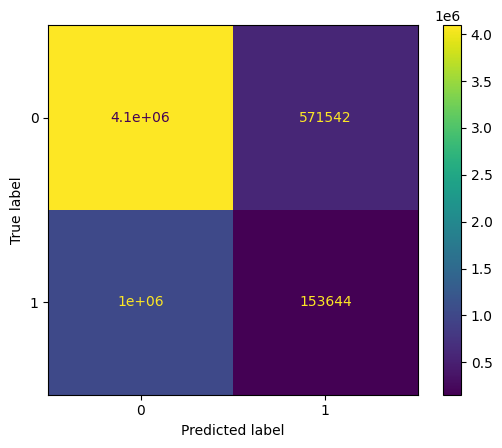

In [45]:
# We can visualise the confusion matrix as follows.
cmplot = ConfusionMatrixDisplay(confusion_matrix(flights_test['Disruption'], predictions_sgd))
cmplot.plot()

In [46]:
# it's hard to gauge the results in the confusion matrix due to the imbalanced classes.
# We therefore compute for the F1, precision, and recall scores.
# Here we see that the model performed very poorly, with very low precision and even lower recall.
# In other words, the model only correctly predicted 'Disruptions' 21% of the time, and of those predictions, only 13% of all 'Disruptions' were captured. 

f1_finalscore = f1_score(flights_test['Disruption'], predictions_sgd).round(5)
precision__finalscore = precision_score(flights_test['Disruption'], predictions_sgd).round(5)
recall_finalscore =  recall_score(flights_test['Disruption'], predictions_sgd).round(5)

f1_row = ["F1 Score", f1_finalscore]
precision_row = ["Precision Score", precision__finalscore]
recall_row = ["Recall Score", recall_finalscore]

results_columns = ['Metric', 'Score']

results_df = pd.DataFrame(data=[f1_row, precision_row, recall_row], columns=results_columns)

print ("Table 5: Final SGD Classifier Scores")
results_df


Table 5: Final SGD Classifier Scores


,Metric,Score
0,F1 Score,0.16210
1,Precision Score,0.21187
2,Recall Score,0.13126


In [47]:
# As a final test, we test the models with actual disrupted flights. Here, it is able to correctly predict 2 out of the 3 flights.

# A Delta Air Lines flight from Reagan Airport (Virginia) to Atlanta International Airport at 5:45pm in the first quarter of the year
row_1 = [547,
         1705,
         1,
         28,
         1,
         'DL',
         'DL',
         11278,
         10397]

# A Delta Air Lines flight from Atlanta to North Carolina at 3:13pm in the 2nd quarter of the year
row_2 = [226,
         1513,
         2,
         29,
         3,
         'DL',
         'DL',
         11057,
         11057]

# An Ameraican Airlines flight from Tampa, Florida to Chicago O'Hare at 2:3pm in the 1st quarter of the year
row_3 = [1011, 
         1435, 
         1,
         1,
         7,
         'AA',
         'AA',
         15304,
         13930]

column_names= ['Distance',
               'CRSDepTime',
               'Quarter',
               'DayofMonth',
               'DayOfWeek',
               'IATA_Code_Marketing_Airline',
               'Operating_Airline',
               'OriginAirportID',
               'DestAirportID']

new_data = pd.DataFrame(data=[row_1, row_2, row_3], columns=column_names)
new_data


,Distance,CRSDepTime,Quarter,DayofMonth,DayOfWeek,IATA_Code_Marketing_Airline,Operating_Airline,OriginAirportID,DestAirportID
0,547,1705,1,28,1,DL,DL,11278,10397
1,226,1513,2,29,3,DL,DL,11057,11057
2,1011,1435,1,1,7,AA,AA,15304,13930


In [48]:
# We transform the data before predicting
new_data_prepared = pipeline.transform(new_data)

print ("The models should predict all three flights as disrupted.\nIn other words, the predictions should show: [1 1 1].")
print ("SGD classifier's predictions: ", (sgd_classifier_0005.predict(new_data_prepared)))


The models should predict all three flights as disrupted.
In other words, the predictions should show: [1 1 1].
SGD classifier's predictions:  [1 0 1]


## Results and Discussion

In terms of COVID's effect on flights, there were fewer flights (and flight disruptions) in the years 2020 and 2021, and a chi-square test resulted in a p-value of 0.999, which means that there is no significant difference in COVID and non-COVID years in terms of flight disruptions.

The machine learning models trained on the flight data initially showed poor F1 scores of around 0.35, and further fine-tuning did not improve this significantly. 

Further evaluation showed the SGD model very performed poorly with an F1 score of 0.1621. The model only correctly predicted 'Disruptions' 21% of the time, and of those predictions, only 13% of all 'Disruptions' were captured.

When tested against past flights, the model did predict 2 out of 3 scenarios, however we cannot predict future flights at this stage. The poor F1, precision, and recall scores show that further data wrangling and training are needed for an effective predictive model. On a lighter note, we can advise airline companies that COVID-19 did not have a significant effect on airline disruptions, so future pandemics should not severely affect these future flights.






## References
BENYBENY. (2017, December 30). Correlation among multiple categorical variables. Stack Overflow. https://stackoverflow.com/questions/48035381/correlation-among-multiple-categorical-variables 


Géron, A. (2023). Hands-on machine learning with scikit-learn, keras and tensorflow: Concepts, tools, and techniques to build Intelligent Systems. O’Reilly Media, Inc. 

Google. (n.d.). Classification: Accuracy . Google for Developers. https://developers.google.com/machine-learning/crash-course/classification/accuracy

Mulla, R. (n.d.). Flight Status Prediction. Kaggle. https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022 

Numpy.where. numpy.where - NumPy v1.26 Manual. (n.d.). https://numpy.org/doc/stable/reference/generated/numpy.where.html 

Singh, G. (2014, January 20). *Import multiple CSV files into pandas and concatenate into one DataFrame*. Stack Overflow. https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe

*Sklearn.metrics.f1_score. Scikit Learn*. (n.d.). https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html 

Yahya. (2020b, June 30). *Convergencewarning: Lbfgs failed to converge (status=1): Stop: Total no. of iterations reached limit*. Stack Overflow. https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter 